In [1]:
!pip install text_hammer

In [2]:
import pandas as pd
import numpy as np
import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,TFBertModel
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

In [63]:
df_train = pd.read_csv(r'C:\Users\prani\Downloads\archive\training.csv')
df_test = pd.read_csv(r'C:\Users\prani\Downloads\archive\test.csv')
df_val=pd.read_csv(r'C:\Users\prani\Downloads\archive\validation.csv')

In [64]:
df_full = pd.concat([df_train,df_test,df_val], axis = 0)
df_full

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
1995,im having ssa examination tomorrow in the morn...,0
1996,i constantly worry about their fight against n...,1
1997,i feel its important to share this info for th...,1
1998,i truly feel that if you are passionate enough...,1


In [65]:
import numpy as np
import pandas as pd
import string

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
colors = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(colors))
matplotlib.rcParams['figure.figsize'] = 12, 8

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [66]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
df_full['description'] = df_full['label'].map(labels_dict )
df_full.head()



,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [67]:
df_full['description'].value_counts(normalize=True)

description
joy         0.33805
sadness     0.28985
anger       0.13545
fear        0.11865
love        0.08205
surprise    0.03595
Name: proportion, dtype: float64

In [68]:
print(type(df_full))


<class 'pandas.core.frame.DataFrame'>


In [69]:
df_full = pd.DataFrame(df_full)


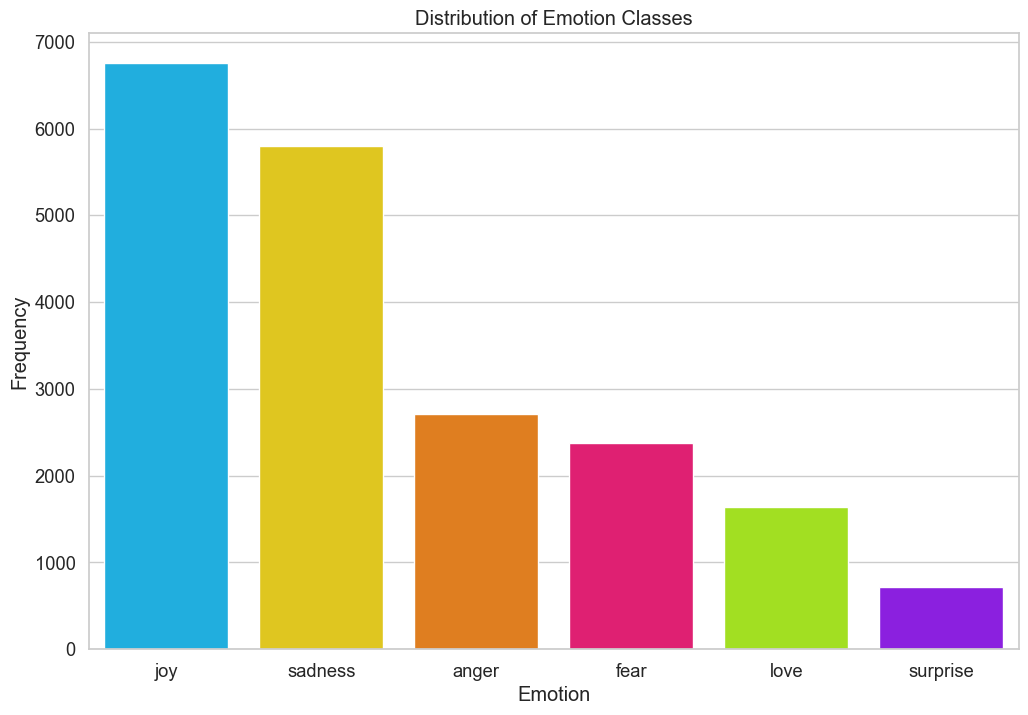

In [70]:
emotion_count = df_full['description'].value_counts()
sns.barplot(x=emotion_count.index, y=emotion_count.values)
plt.title('Distribution of Emotion Classes')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()


In [71]:
df_full['text_length'] = df_full['text'].astype(str).apply(len)
df_full['text_word_count'] = df_full['text'].apply(lambda x: len(str(x).split()))

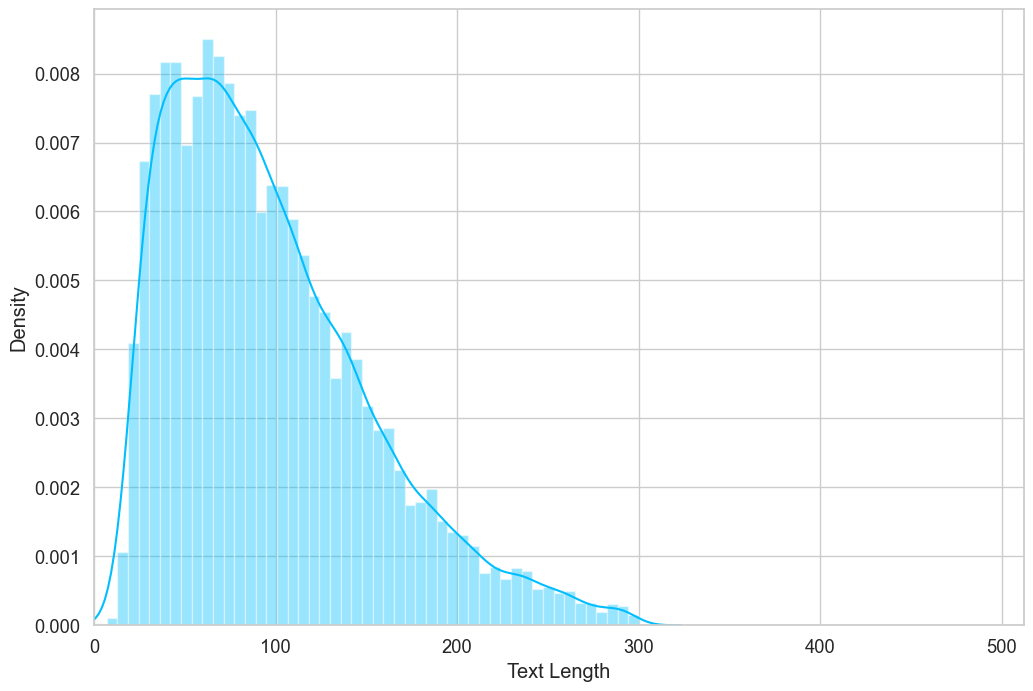

In [72]:
sns.distplot(df_full['text_length'])
plt.xlim([0, 512]);
plt.xlabel('Text Length');


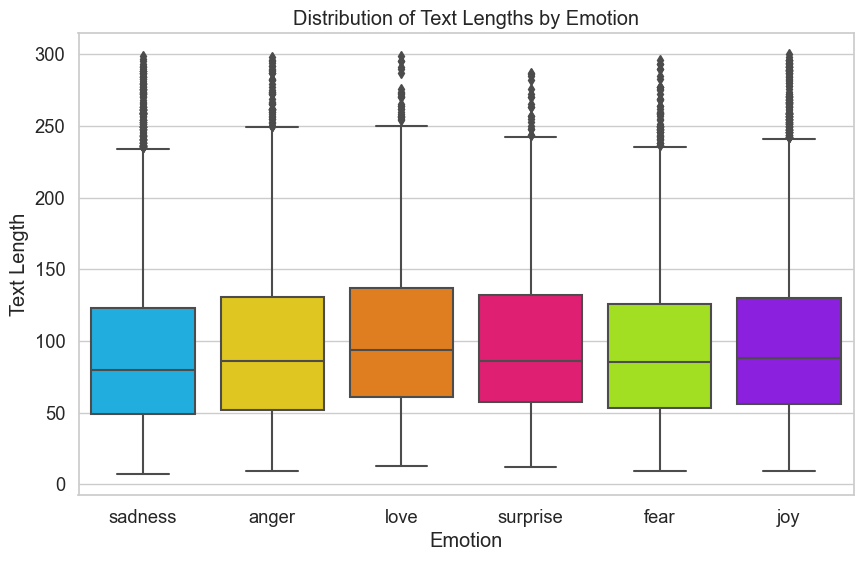

In [73]:
df_full['text_length'] = df_full['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.boxplot(x='description', y='text_length', data=df_full)
plt.title('Distribution of Text Lengths by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Text Length')
plt.show()


In [74]:
# Creating individual dataframes of different emotions
sadness = df_full[df_full['label']==0]['text']
joy = df_full[df_full['label']==1]['text']
love = df_full[df_full['label']==2]['text']
anger = df_full[df_full['label']==3]['text']
fear = df_full[df_full['label']==4]['text']
surprise = df_full[df_full['label']==5]['text']

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [76]:
sad_unigrams = get_top_n_gram(sadness.values,(1,1),7)[2:]
joy_unigrams= get_top_n_gram(joy.values,(1,1),7)[2:]
love_unigrams= get_top_n_gram(love.values,(1,1),7)[2:]
anger_unigrams= get_top_n_gram(anger.values,(1,1),7)[2:]
fear_unigrams= get_top_n_gram(fear.values,(1,1),7)[2:]
surprise_unigrams= get_top_n_gram(surprise.values,(1,1),7)[2:]



sad_bigrams = get_top_n_gram(sadness.values,(2,2),7)[2:]
joy_bigrams= get_top_n_gram(joy.values,(2,2),7)[2:]
love_bigrams= get_top_n_gram(love.values,(2,2),7)[2:]
anger_bigrams= get_top_n_gram(anger.values,(2,2),7)[2:]
fear_bigrams= get_top_n_gram(fear.values,(2,2),7)[2:]
surprise_bigrams= get_top_n_gram(surprise.values,(2,2),7)[2:]


sad_trigrams = get_top_n_gram(sadness.values,(3,3),7)[2:]
joy_trigrams= get_top_n_gram(joy.values,(3,3),7)[2:]
love_trigrams= get_top_n_gram(love.values,(3,3),7)[2:]
anger_trigrams= get_top_n_gram(anger.values,(3,3),7)[2:]
fear_trigrams= get_top_n_gram(fear.values,(3,3),7)[2:]
surprise_trigrams= get_top_n_gram(surprise.values,(3,3),7)[2:]

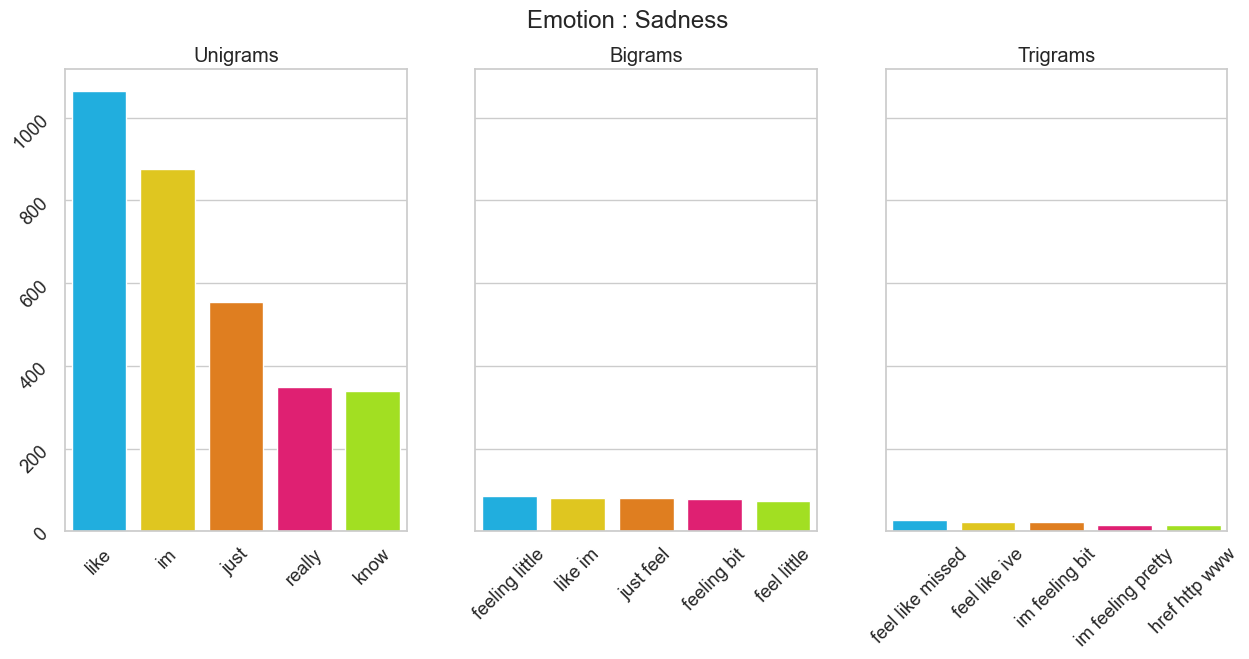

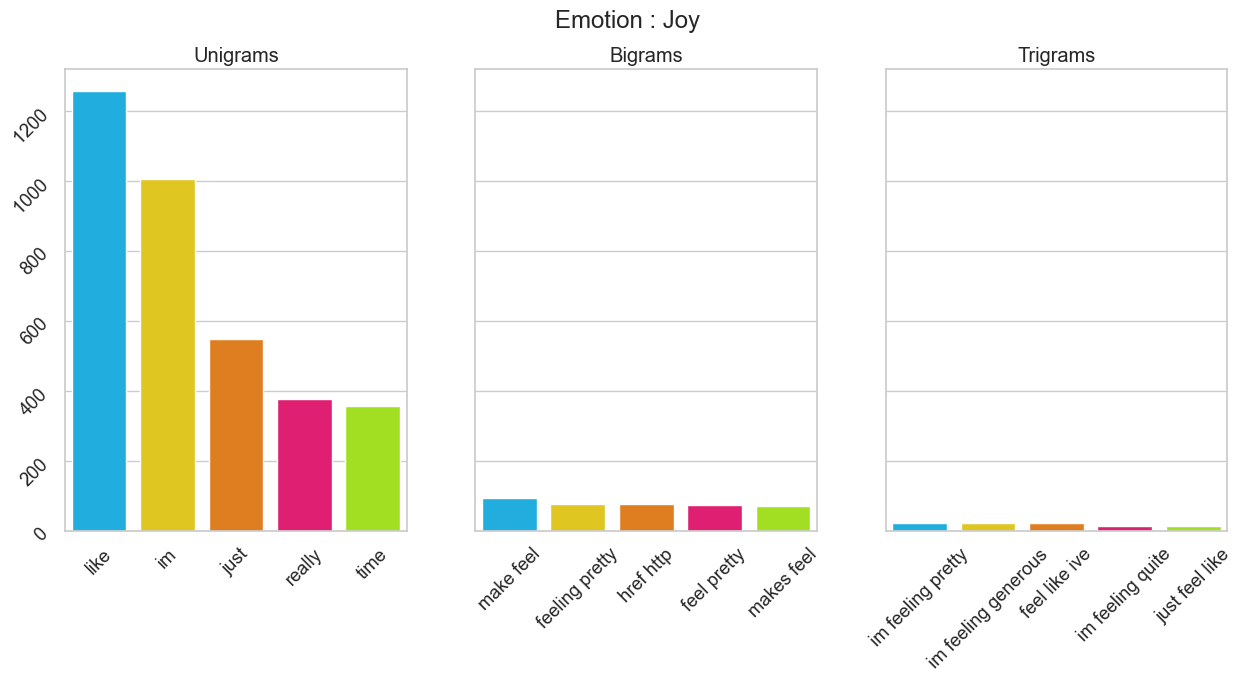

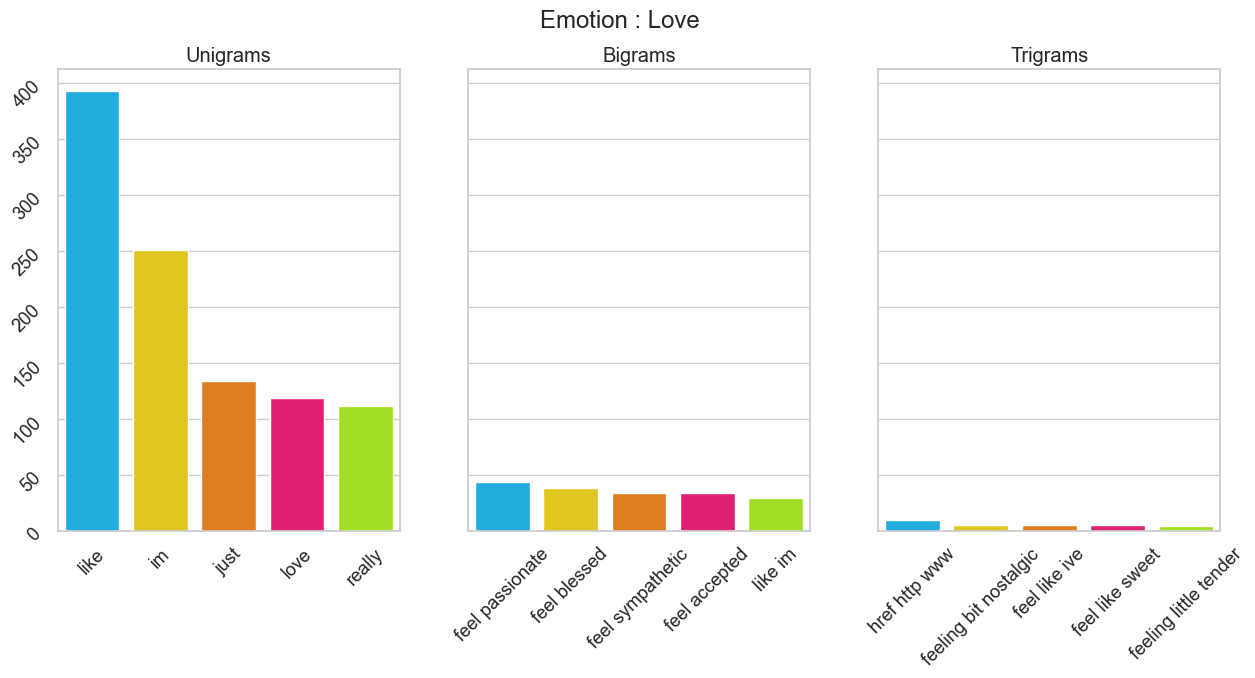

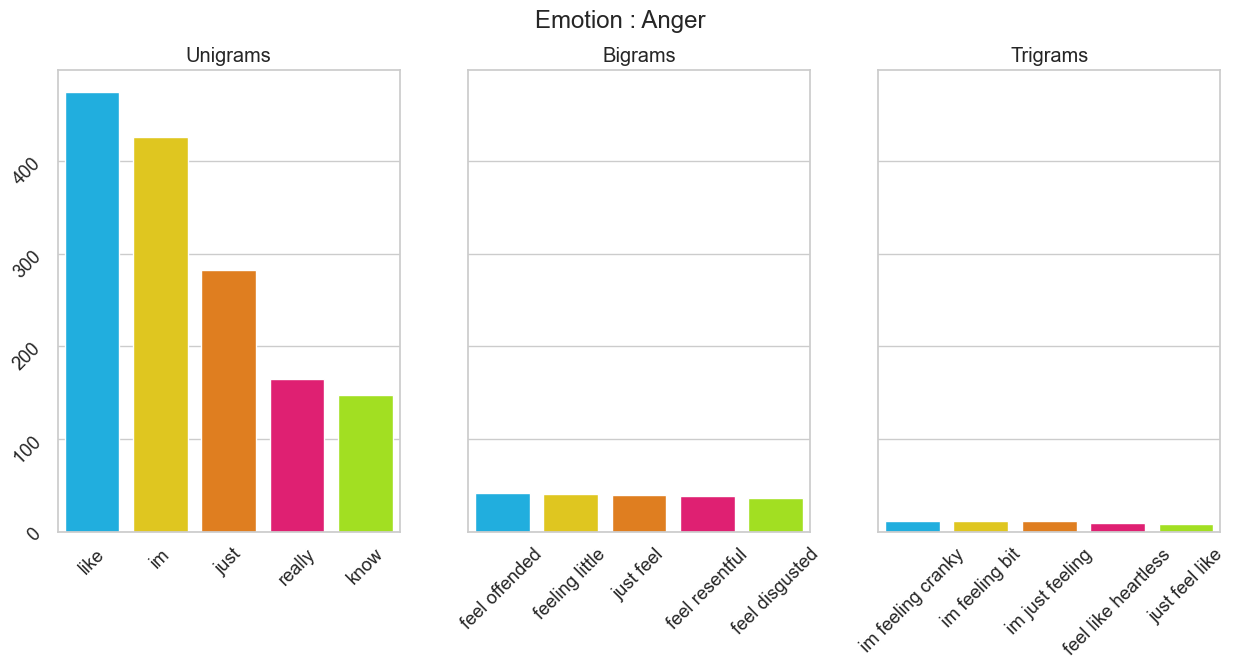

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
fig.suptitle('Emotion : Sadness')



sns.barplot( x=list(dict(sad_unigrams).keys()), y=list(dict(sad_unigrams).values()),ax=axes[0],)
axes[0].set_title('Unigrams')
axes[0].tick_params(labelrotation=45)



sns.barplot( x=list(dict(sad_bigrams).keys()), y=list(dict(sad_bigrams).values()),ax=axes[1],)
axes[1].set_title('Bigrams')
axes[1].tick_params(labelrotation=45)



sns.barplot( x=list(dict(sad_trigrams).keys()), y=list(dict(sad_trigrams).values()),ax=axes[2],)
axes[2].set_title('Trigrams')
axes[2].tick_params(labelrotation=45)
fig.savefig('sadness.png')


#Joy

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
fig.suptitle('Emotion : Joy')

sns.barplot( x=list(dict(joy_unigrams).keys()), y=list(dict(joy_unigrams).values()),ax=axes[0],)
axes[0].set_title('Unigrams')
axes[0].tick_params(labelrotation=45)

sns.barplot( x=list(dict(joy_bigrams).keys()), y=list(dict(joy_bigrams).values()),ax=axes[1],)
axes[1].set_title('Bigrams')
axes[1].tick_params(labelrotation=45)


sns.barplot( x=list(dict(joy_trigrams).keys()), y=list(dict(joy_trigrams).values()),ax=axes[2],)
axes[2].set_title('Trigrams')
axes[2].tick_params(labelrotation=45)
fig.savefig('joy.png')

#Love

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
fig.suptitle('Emotion : Love')

sns.barplot( x=list(dict(love_unigrams).keys()), y=list(dict(love_unigrams).values()),ax=axes[0],)
axes[0].set_title('Unigrams')
axes[0].tick_params(labelrotation=45)

sns.barplot(x=list(dict(love_bigrams).keys()), y=list(dict(love_bigrams).values()),ax=axes[1],)
axes[1].set_title('Bigrams')
axes[1].tick_params(labelrotation=45)


sns.barplot( x=list(dict(love_trigrams).keys()), y=list(dict(love_trigrams).values()),ax=axes[2],)
axes[2].set_title('Trigrams')
axes[2].tick_params(labelrotation=45)


#Anger
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
fig.suptitle('Emotion : Anger')

sns.barplot( x=list(dict(anger_unigrams).keys()), y=list(dict(anger_unigrams).values()),ax=axes[0],)
axes[0].set_title('Unigrams')
axes[0].tick_params(labelrotation=45)

sns.barplot( x=list(dict(anger_bigrams).keys()), y=list(dict(anger_bigrams).values()),ax=axes[1],)
axes[1].set_title('Bigrams')
axes[1].tick_params(labelrotation=45)



sns.barplot( x=list(dict(anger_trigrams).keys()), y=list(dict(anger_trigrams).values()),ax=axes[2],)
axes[2].set_title('Trigrams')
axes[2].tick_params(labelrotation=45)

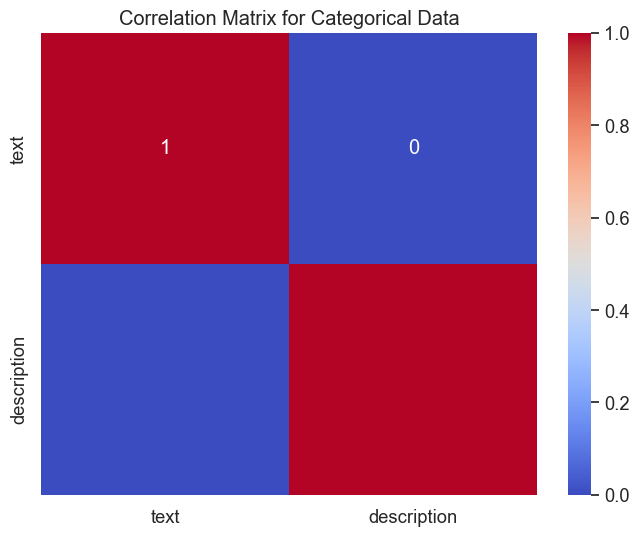

In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Define a function to calculate Cramér's V, which is a measure of categorical association
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# Assuming df is your DataFrame and 'label' and 'description' are the columns
# Convert 'label' and 'description' to category if they are not already
df_full['text'] = df_full['text'].astype('category')
df_full['description'] = df_full['description'].astype('category')

# Calculate Cramér's V for the 'label' and 'description' columns
cramers_v_value = cramers_v(df_full['text'], df_full['description'])

# Create a DataFrame for the correlation matrix
corr_matrix = pd.DataFrame(data=[[1, cramers_v_value], [cramers_v_value, 1]], 
                           index=['text', 'description'], 
                           columns=['text', 'description'])


# Plot the correlation matrix with adjusted color scale limits
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1)  # Set the limits from 0 to 1
plt.title("Correlation Matrix for Categorical Data")
plt.show()

In [80]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
 
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
 
    return(df)

In [81]:
df_cleaned = text_preprocessing(df_full,'text')

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [208]:
df_cleaned

,text,label,description,text_length,text_word_count,num_words
0,i didnt feel humiliated,0,sadness,23,4,4
1,i can go from feeling so hopeless to so damned...,0,sadness,108,21,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,48,10,10
3,i am ever feeling nostalgic about the fireplac...,2,love,92,18,18
4,i am feeling grouchy,3,anger,20,4,4
...,...,...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,0,sadness,191,34,34
1996,i constantly worry about their fight against n...,1,joy,173,29,29
1997,i feel its important to share this info for th...,1,joy,80,15,15
1998,i truly feel that if you are passionate enough...,1,joy,105,19,19


In [203]:
# Grouping texts by 'description' and joining them
grouped_text = df_cleaned.groupby('description')['text'].apply(' '.join)


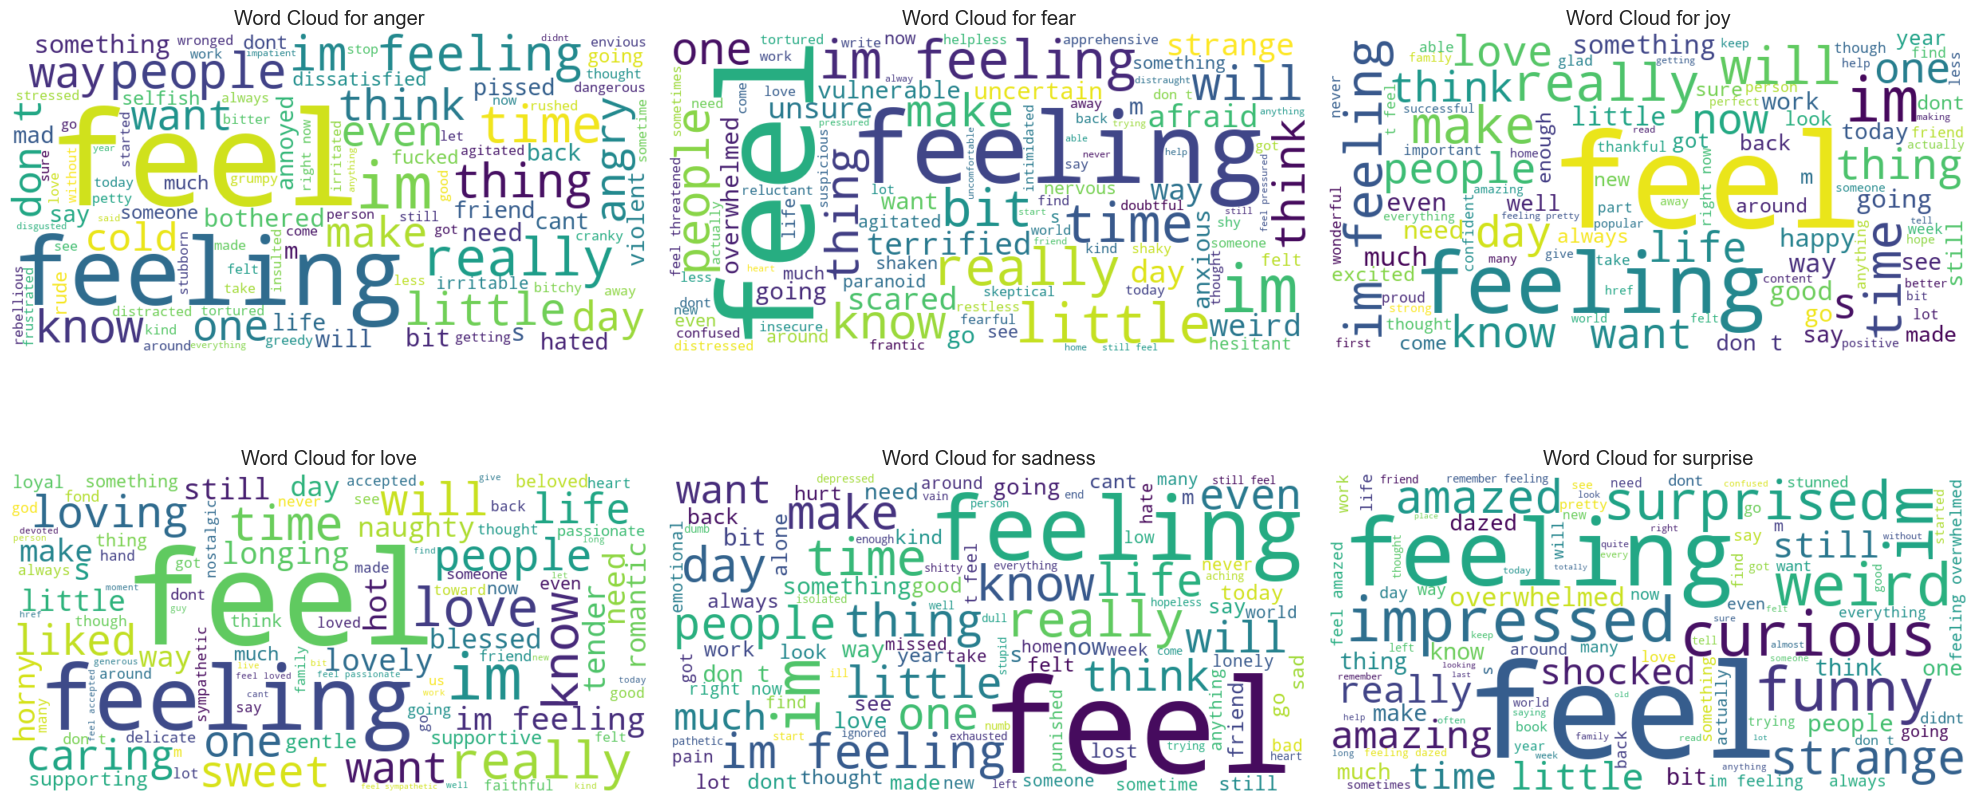

In [204]:
# Set the dimensions of the figure
plt.figure(figsize=(20, 10))

for i, (description, text) in enumerate(grouped_text.items(), 1):
    # Create a word cloud object
    wc = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    
    # Plotting
    plt.subplot(2, 3, i)  # Adjust grid parameters depending on the number of descriptions
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Word Cloud for {description}')
    plt.axis("off")

plt.tight_layout()
plt.show()


In [82]:
# Assuming 'text' column as features and 'label' as target
X = df_cleaned['text']  # the feature data
y = df_cleaned['label']  # the target data


In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [85]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Create a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred_nb = nb_classifier.predict(X_test)

# Evaluate the model
print("Naive Bayes Classifier Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Classifier Accuracy: 0.6193333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.88      0.77      1755
           1       0.56      0.98      0.71      1980
           2       1.00      0.03      0.05       507
           3       0.96      0.15      0.26       831
           4       0.92      0.11      0.20       697
           5       0.00      0.00      0.00       230

    accuracy                           0.62      6000
   macro avg       0.69      0.36      0.33      6000
weighted avg       0.71      0.62      0.52      6000



In [86]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier
dt_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate the model
print("Decision Tree Classifier Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Classifier Accuracy: 0.8485
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      1755
           1       0.87      0.87      0.87      1980
           2       0.75      0.78      0.76       507
           3       0.86      0.84      0.85       831
           4       0.77      0.83      0.80       697
           5       0.73      0.68      0.70       230

    accuracy                           0.85      6000
   macro avg       0.81      0.81      0.81      6000
weighted avg       0.85      0.85      0.85      6000



In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Classifier Accuracy: 0.8561666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1755
           1       0.81      0.94      0.87      1980
           2       0.85      0.68      0.75       507
           3       0.90      0.81      0.85       831
           4       0.84      0.79      0.81       697
           5       0.80      0.66      0.72       230

    accuracy                           0.86      6000
   macro avg       0.85      0.79      0.82      6000
weighted avg       0.86      0.86      0.85      6000



In [202]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [198]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'vectorizer' is already fitted to your training data:
# vectorizer = TfidfVectorizer()
# vectorizer.fit(train_texts)

texts = input(str('Input the text: '))
x_val = vectorizer.transform([texts])  # Convert text to vector
labels_dict = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

Input the text:  i am excited to meet you


In [199]:
# Example for Naive Bayes
nb_prediction = nb_classifier.predict_proba(x_val) * 100
predicted_label = nb_classifier.predict(x_val)[0]
predicted_emotion = labels_dict[predicted_label]

# Display the results
print(f'Predicted emotion: {predicted_emotion}')
for category, probability in zip(nb_classifier.classes_, nb_prediction[0]):
    emotion = labels_dict[category]
    print(f'{emotion}: {probability:.2f}%')


Predicted emotion: joy
sadness: 15.14%
joy: 67.69%
love: 3.18%
anger: 4.96%
fear: 8.58%
surprise: 0.45%


In [200]:
# Example for Decision Tree
dt_prediction = dt_classifier.predict_proba(x_val) * 100
predicted_label_dt = dt_classifier.predict(x_val)[0]
predicted_emotion_dt = labels_dict[predicted_label_dt]

# Display the results
print(f'Predicted emotion: {predicted_emotion_dt}')
for category, probability in zip(dt_classifier.classes_, dt_prediction[0]):
    emotion = labels_dict[category]
    print(f'{emotion}: {probability:.2f}%')


Predicted emotion: joy
sadness: 0.00%
joy: 100.00%
love: 0.00%
anger: 0.00%
fear: 0.00%
surprise: 0.00%


In [201]:
# Example for Random Forest
rf_prediction = rf_classifier.predict_proba(x_val) * 100
predicted_label_rf = rf_classifier.predict(x_val)[0]
predicted_emotion_rf = labels_dict[predicted_label_rf]

# Display the results
print(f'Predicted emotion: {predicted_emotion_rf}')
for category, probability in zip(rf_classifier.classes_, rf_prediction[0]):
    emotion = labels_dict[category]
    print(f'{emotion}: {probability:.2f}%')


Predicted emotion: joy
sadness: 11.00%
joy: 66.00%
love: 10.00%
anger: 2.00%
fear: 10.00%
surprise: 1.00%


In [106]:
# changing the data type to the category to encode into codes 
df_cleaned['label'] = df_cleaned['label'].astype('category')

In [107]:
df_cleaned['label']

0       0
1       0
2       3
3       2
4       3
       ..
1995    0
1996    1
1997    1
1998    1
1999    1
Name: label, Length: 20000, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [108]:
df_cleaned['label'].cat.codes

0       0
1       0
2       3
3       2
4       3
       ..
1995    0
1996    1
1997    1
1998    1
1999    1
Length: 20000, dtype: int8

In [165]:
encoded_dict  = {'sadness':0,'joy':1, 'love':2, 'anger':3, 'fear':4, 'surprise':5}

In [166]:
df_cleaned.num_words.max()

66

In [167]:
data_train,data_test = train_test_split(df_cleaned, test_size = 0.3, random_state = 42, stratify = df_cleaned['label'])

In [168]:
data_train.shape

(14000, 6)

In [169]:
data_test.shape

(6000, 6)

In [170]:
to_categorical(data_train['label'])

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [171]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

In [172]:
# for saving model locally and we can load it later on 
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')

In [173]:
shutil.make_archive('bert-tokenizer', 'zip', 'bert-tokenizer')
shutil.make_archive('bert-model','zip','bert-model')

'C:\\Users\\prani\\bert-model.zip'

In [174]:
tokenizer('I will be kaggle grandmaster')


{'input_ids': [101, 146, 1209, 1129, 24181, 25186, 5372, 6532, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [175]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=data_train['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


In [176]:
x_test['input_ids']

<tf.Tensor: shape=(6000, 70), dtype=int32, numpy=
array([[ 101,  178, 1243, ...,    0,    0,    0],
       [ 101,  178, 1631, ...,    0,    0,    0],
       [ 101,  178, 2810, ...,    0,    0,    0],
       ...,
       [ 101,  178, 1838, ...,    0,    0,    0],
       [ 101,  178, 1238, ...,    0,    0,    0],
       [ 101,  178, 4534, ...,    0,    0,    0]])>

In [177]:
from transformers import TFBertModel
bert = TFBertModel.from_pretrained('bert-base-uncased')


In [178]:
print(tf.executing_eagerly())


True


In [179]:
import tensorflow as tf
from transformers import TFBertModel

# Prepare a simple input example
input_ids = tf.constant([[101, 1037, 2732, 102]])  # example input token IDs
attention_mask = tf.constant([[1, 1, 1, 1]])       # example attention mask

# Load the pre-trained BERT model
model = TFBertModel.from_pretrained('bert-base-uncased')

# Make a prediction
outputs = model(input_ids, attention_mask=attention_mask)

# Print the output of the last hidden state
print(outputs.last_hidden_state)


tf.Tensor(
[[[-0.39525095  0.15090112 -0.48279536 ... -0.25978786  0.349711
    0.2008431 ]
  [-0.04082784  0.23606957 -0.25727886 ... -0.26797667  0.48936227
    0.04938456]
  [-0.43519858 -0.06816684 -0.5273032  ... -0.202594    0.34412754
   -0.65167165]
  [ 0.7107709   0.14637792 -0.35833487 ...  0.2829962  -0.7334039
   -0.26128694]]], shape=(1, 4, 768), dtype=float32)


In [180]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Dropout, GlobalMaxPool1D
from transformers import TFBertModel
from tensorflow.keras.models import Model

class BertLayer(Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        return self.bert(input_ids, attention_mask=attention_mask, return_dict=True).last_hidden_state


In [181]:
# Define the inputs
input_ids = Input(shape=(70,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(70,), dtype='int32', name='attention_mask')

# Use the custom BERT layer
bert_output = BertLayer()([input_ids, attention_mask])
pooled_output = GlobalMaxPool1D()(bert_output)

# Add further layers
dense = Dense(128, activation='relu')(pooled_output)
dropout = Dropout(0.1)(dense)
final_output = Dense(6, activation='sigmoid')(dropout)

# Create and compile the model
model = Model(inputs=[input_ids, attention_mask], outputs=final_output)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_1        │ (None, 70, 768)   │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 768)       │          0 │ bert_layer_1[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     98,432 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │        774 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,206 (387.52 KB)

 Trainable params: 99,206 (387.52 KB)

 Non-trainable params: 0 (0.00 B)

In [182]:
# Example dummy data to test the model (make sure to replace with actual data or remove this if not testing immediately)
import numpy as np
test_input_ids = np.random.randint(0, 2000, size=(10, 70))
test_attention_mask = np.random.randint(0, 2, size=(10, 70))

# Run a prediction (or model.fit if you have actual training data)
print(model.predict([test_input_ids, test_attention_mask]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0.78626174 0.2838247  0.8596942  0.20964587 0.4004808  0.5634324 ]
 [0.76032776 0.4301224  0.7753673  0.4378078  0.61825484 0.19948515]
 [0.72414356 0.36249313 0.8102445  0.4645512  0.55159265 0.32628676]
 [0.8300466  0.32285643 0.79219246 0.46391234 0.5344377  0.3231155 ]
 [0.7380929  0.2986577  0.77202225 0.49071968 0.5304936  0.35670215]
 [0.76936597 0.31950912 0.84385794 0.5536497  0.5220012  0.33773303]
 [0.7548432  0.4417061  0.79721797 0.5415737  0.64259833 0.24290031]
 [0.6998807  0.2818025  0.77086097 0.46399578 0.52117974 0.33955014]
 [0.647542   0.27510396 0.80020356 0.5022015  0.5314064  0.39973074]
 [0.7743703  0.37154943 0.79573196 0.4647105  0.41374543 0.34984827]]


In [183]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

optimizer = Adam(
    learning_rate=5e-05,  # This learning rate is for BERT model, taken from the Hugging Face website
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

# Set loss and metrics
loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]  # Ensure this is a list
)


In [184]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [185]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

In [186]:
####Check if the variables are defined
print("x_train defined:", 'x_train' in locals() or 'x_train' in globals())
print("x_test defined:", 'x_test' in locals() or 'x_test' in globals())
print("data_train defined:", 'data_train' in locals() or 'data_train' in globals())
print("data_test defined:", 'data_test' in locals() or 'data_test' in globals())


x_train defined: True
x_test defined: True
data_train defined: True
data_test defined: True


In [187]:
from tensorflow.keras.metrics import CategoricalAccuracy

# Correct way to define and compile the model with metrics
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Assuming your model is doing classification with softmax
    metrics=[CategoricalAccuracy(name='balanced_accuracy')]  # Correctly pass the metric as a list
)


In [188]:
from tensorflow.keras.utils import to_categorical

train_history = model.fit(
    x={'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']},
    y=to_categorical(data_train['label']),  # Convert labels to one-hot encoding
    validation_data=(
        {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']},
        to_categorical(data_test['label'])  # Convert validation labels to one-hot encoding
    ),
    epochs=1,
    batch_size=36
)


389/389 ━━━━━━━━━━━━━━━━━━━━ 3528s 8s/step - balanced_accuracy: 0.2921 - loss: 1.6999 - val_balanced_accuracy: 0.3447 - val_loss: 1.5839


In [189]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

188/188 ━━━━━━━━━━━━━━━━━━━━ 474s 3s/step


In [190]:
predicted_raw[0]

array([0.7935417 , 0.69678694, 0.43763122, 0.41834363, 0.40069988,
       0.12548336], dtype=float32)

In [191]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_predicted

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [192]:
data_test['label']

2950     1
11631    1
8685     1
10305    0
11829    0
        ..
2666     1
6556     3
14591    0
1748     3
4950     4
Name: label, Length: 6000, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [193]:
accuracy_score(data_test['label'],y_predicted)

0.3446666666666667

In [194]:
print(classification_report(data_test['label'], y_predicted))

              precision    recall  f1-score   support

           0       0.34      0.26      0.30      1739
           1       0.35      0.79      0.48      2028
           2       0.00      0.00      0.00       492
           3       0.15      0.00      0.00       813
           4       1.00      0.00      0.00       712
           5       0.00      0.00      0.00       216

    accuracy                           0.34      6000
   macro avg       0.31      0.18      0.13      6000
weighted avg       0.35      0.34      0.25      6000



In [196]:
texts = input(str('input the text'))

x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
validation

input the text i am excited to meet you


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[67.33035 , 66.626656, 44.92167 , 51.327312, 48.566895, 25.680408]],
      dtype=float32)

In [197]:
for key , value in zip(encoded_dict.keys(),validation[0]):
    print(key,value)

sadness 67.33035
joy 66.626656
love 44.92167
anger 51.327312
fear 48.566895
surprise 25.680408


In [212]:
!pip install streamlit

  Obtaining dependency information for streamlit from https://files.pythonhosted.org/packages/b7/f9/9ad1e6e33e4ae149aead1ee8062e536d060b50d650df710899805562910a/streamlit-1.33.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for altair<6,>=4.0 from https://files.pythonhosted.org/packages/46/30/2118537233fa72c1d91a81f5908a7e843a6601ccc68b76838ebc4951505f/altair-5.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for blinker<2,>=1.0.0 from https://files.pythonhosted.org/packages/fa/2a/7f3714cbc6356a0efec525ce7a0613d581072ed6eb53eb7b9754f33db807/blinker-1.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for cachetools<6,>=4.0 from https://files.pythonhosted.org/packages/fb/2b/a64c2d25a37aeb921fddb929111413049fc5f8b9a4c1aefaffaafe768d54/cachetools-5.3.3-py3-none-any.whl.metadata
  Obtaining dependency information for gitpython!=3.1.19,<4,>=3.0.7 from https://files.pythonhosted.org/packages/e9/bd/cc3a402a6439c15c3d4294333e13042b915bbeab54edc4